In [1]:
import os, glob, sys, io
from pprint import pprint
import numpy as np
import pandas as pd
import tensorflow as tf

import ismrmrd
import ismrmrdtools

In [2]:
def toStr(x):
    if isinstance(x, bytes): return x.decode("utf-8")
    else: return str(x) 

In [3]:
data_dir = r'H:\Dataset\Bio\MRI Reconstruction\mridata'
tables = pd.read_csv('mridata.csv')
uuid = tables.iloc[0]['UUID']
filename = os.path.join(data_dir, uuid+".h5")
tables

,UUID,Downloads,References,Comments,Funding Support,Protocol Name,Series Description,System Vendor,System Model,System Field Strength,...,Number of Contrasts,Trajectory,Parallel Imaging Factor,Repetition Time,Echo Time,Inversion Time,Flip Angle,Sequence Type,Echo Spacing,Upload Date
0,413469fd-9354-400c-88e3-b29e7c711a05,2153,"Hammernik K, Klatzer T, Kobler E, Recht M, Sod...",This is part of the training and test data tha...,NIH P41 EB017183,SAG,SAG,SIEMENS,Skyra,2.89362 T,...,1,cartesian,1.0 x 1.0,2800 ms,22 ms,100 ms,150 °,TurboSpinEcho,11.12 ms,"Aug. 8, 2018, 7:12 a.m."
1,6a8fff64-9bba-4ce7-aa58-d024214b4d7a,4757,"Hammernik K, Klatzer T, Kobler E, Recht M, Sod...",This is part of the training and test data tha...,NIH P41 EB017183,SAG,SAG,SIEMENS,Skyra,2.89362 T,...,1,cartesian,1.0 x 1.0,2800 ms,22 ms,100 ms,150 °,TurboSpinEcho,11.12 ms,"Aug. 8, 2018, 7:12 a.m."
2,bd01dd30-46e7-4415-bf04-ed4cc6ac2b64,1162,"Hammernik K, Klatzer T, Kobler E, Recht M, Sod...",This is part of the training and test data tha...,NIH P41 EB017183,SAG,SAG,SIEMENS,Skyra,2.89362 T,...,1,cartesian,1.0 x 1.0,2800 ms,22 ms,100 ms,150 °,TurboSpinEcho,11.12 ms,"Aug. 8, 2018, 7:11 a.m."
3,6493682f-c9d3-44a7-8c0f-7fdf8b165410,1090,"Hammernik K, Klatzer T, Kobler E, Recht M, Sod...",This is part of the training and test data tha...,NIH P41 EB017183,SAG,SAG,SIEMENS,Skyra,2.89362 T,...,1,cartesian,1.0 x 1.0,2800 ms,22 ms,100 ms,150 °,TurboSpinEcho,11.12 ms,"Aug. 8, 2018, 7:10 a.m."
4,48c95dcf-c074-499b-a63c-74f0bf7dff1f,1141,"Hammernik K, Klatzer T, Kobler E, Recht M, Sod...",This is part of the training and test data tha...,NIH P41 EB017183,SAG,SAG,SIEMENS,Skyra,2.89362 T,...,1,cartesian,1.0 x 1.0,2800 ms,22 ms,100 ms,150 °,TurboSpinEcho,11.12 ms,"Aug. 8, 2018, 7:09 a.m."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,a5d10e70-627b-4a4c-943b-0639fd2cee8d,385,"Hammernik K, Klatzer T, Kobler E, Recht M, Sod...",This is part of the training and test data tha...,NIH P41 EB017183,COR,COR,SIEMENS,Skyra,2.89362 T,...,1,cartesian,1.0 x 1.0,3170 ms,33 ms,100 ms,180 °,TurboSpinEcho,10.96 ms,"Aug. 6, 2018, 12:16 p.m."
96,9616b2e4-81fc-4bd5-bee0-e3aac05cd0a5,383,"Hammernik K, Klatzer T, Kobler E, Recht M, Sod...",This is part of the training and test data tha...,NIH P41 EB017183,COR,COR,SIEMENS,Skyra,2.89362 T,...,1,cartesian,1.0 x 1.0,2870 ms,33 ms,100 ms,180 °,TurboSpinEcho,10.96 ms,"Aug. 6, 2018, 12:14 p.m."
97,4ed55066-656a-46aa-af95-81667b4f565b,381,"Hammernik K, Klatzer T, Kobler E, Recht M, Sod...",This is part of the training and test data tha...,NIH P41 EB017183,COR,COR,SIEMENS,Skyra,2.89362 T,...,1,cartesian,1.0 x 1.0,2870 ms,33 ms,100 ms,180 °,TurboSpinEcho,10.96 ms,"Aug. 6, 2018, 12:12 p.m."
98,be92c2de-4b73-4f07-a081-73973bf5d037,385,"Hammernik K, Klatzer T, Kobler E, Recht M, Sod...",This is part of the training and test data tha...,NIH P41 EB017183,COR,COR,SIEMENS,Skyra,2.89362 T,...,1,cartesian,1.0 x 1.0,3010 ms,33 ms,100 ms,180 °,TurboSpinEcho,10.96 ms,"Aug. 6, 2018, 12:10 p.m."


In [4]:

# Load file
if not os.path.isfile(filename):
    print("%s is not a valid file" % filename)
    raise SystemExit
dset = ismrmrd.Dataset(filename, 'dataset', create_if_needed=False)

header = ismrmrd.xsd.CreateFromDocument(dset.read_xml_header())
enc = header.encoding[0]

# Matrix size
eNx = enc.encodedSpace.matrixSize.x
eNy = enc.encodedSpace.matrixSize.y
eNz = enc.encodedSpace.matrixSize.z
rNx = enc.reconSpace.matrixSize.x
rNy = enc.reconSpace.matrixSize.y
rNz = enc.reconSpace.matrixSize.z

# Field of View
eFOVx = enc.encodedSpace.fieldOfView_mm.x
eFOVy = enc.encodedSpace.fieldOfView_mm.y
eFOVz = enc.encodedSpace.fieldOfView_mm.z
rFOVx = enc.reconSpace.fieldOfView_mm.x
rFOVy = enc.reconSpace.fieldOfView_mm.y
rFOVz = enc.reconSpace.fieldOfView_mm.z

# Number of Slices, Reps, Contrasts, etc.
ncoils = header.acquisitionSystemInformation.receiverChannels
if enc.encodingLimits.slice != None:
    nslices = enc.encodingLimits.slice.maximum + 1
else:
    nslices = 1


if enc.encodingLimits.repetition != None:
    nreps = enc.encodingLimits.repetition.maximum + 1
else:
    nreps = 1

if enc.encodingLimits.contrast != None:
    ncontrasts = enc.encodingLimits.contrast.maximum + 1
else:
    ncontrasts = 1

In [5]:
eNx, eNy, eNz

(768, 770, 1)

In [6]:
rNx, rNy, rNz

(384, 384, 1)

In [7]:
eFOVx, eFOVy, eFOVz

(280.0, 280.700012, 4.5)

In [8]:
rFOVx, rFOVy, rFOVz

(140.0, 140.0, 3.0)

In [9]:
ncoils, nslices, nreps, ncontrasts

(15, 31, 1, 1)

In [10]:

# TODO loop through the acquisitions looking for noise scans
firstacq=0
for acqnum in range(dset.number_of_acquisitions()):
    acq = dset.read_acquisition(acqnum)
    
    # TODO: Currently ignoring noise scans
    if acq.isFlagSet(ismrmrd.ACQ_IS_NOISE_MEASUREMENT):
        print("Found noise scan at acq ", acqnum)
        continue
    else:
        firstacq = acqnum
        print("Imaging acquisition starts acq ", acqnum)
        break


Imaging acquisition starts acq  0


In [11]:
import os
import ismrmrd
import ismrmrd.xsd
import numpy as np

from ismrmrdtools import show, transform


remove_oversampling_x = True

# Initialiaze a storage array
all_data = np.zeros((nreps, ncontrasts, nslices, ncoils, eNz, eNy, rNx if remove_oversampling_x else eNx), 
                    dtype=np.complex64)

# Loop through the rest of the acquisitions and stuff
for acqnum in range(firstacq,dset.number_of_acquisitions()):
    acq = dset.read_acquisition(acqnum)

    # TODO: this is where we would apply noise pre-whitening

    # Remove oversampling if needed
    if remove_oversampling_x and eNx != rNx:
        xline = transform.transform_kspace_to_image(acq.data, [1])
        x0 = (eNx - rNx) // 2
        x1 = (eNx - rNx) // 2 + rNx
        xline = xline[:,x0:x1]
        acq.resize(rNx,acq.active_channels,acq.trajectory_dimensions)
        acq.center_sample = rNx//2
        # need to use the [:] notation here to fill the data
        acq.data[:] = transform.transform_image_to_kspace(xline, [1])
  
    # Stuff into the buffer
    rep = acq.idx.repetition
    contrast = acq.idx.contrast
    slice = acq.idx.slice
    y = acq.idx.kspace_encode_step_1
    z = acq.idx.kspace_encode_step_2
    all_data[rep, contrast, slice, :, z, y, :] = acq.data

In [12]:
# Reconstruct images
images = np.zeros((nreps, ncontrasts, nslices, eNz, eNy, rNx if remove_oversampling_x else eNx), 
                  dtype=np.float32)
for rep in range(nreps):
    for contrast in range(ncontrasts):
        for slice in range(nslices):
            # FFT
            if eNz>1:
                #3D
                im = transform.transform_kspace_to_image(all_data[rep,contrast,slice,:,:,:,:], [1,2,3])
            else:
                #2D
                im = transform.transform_kspace_to_image(all_data[rep,contrast,slice,:,0,:,:], [1,2])

            # Sum of squares
            im = np.sqrt(np.sum(np.abs(im) ** 2, 0))
            
            # Stuff into the output
            if eNz>1:
                #3D
                images[rep,contrast,slice,:,:,:] = im
            else:
                #2D
                images[rep,contrast,slice,0,:,:] = im

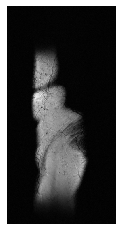

In [13]:
# Show an image
show.imshow(np.squeeze(images[0,0,0,:,:,:]), cmap='gray')

In [14]:
all_data.shape

(1, 1, 31, 15, 1, 770, 384)

In [15]:
img = np.squeeze(images) / images.max()
img.shape

(31, 770, 384)

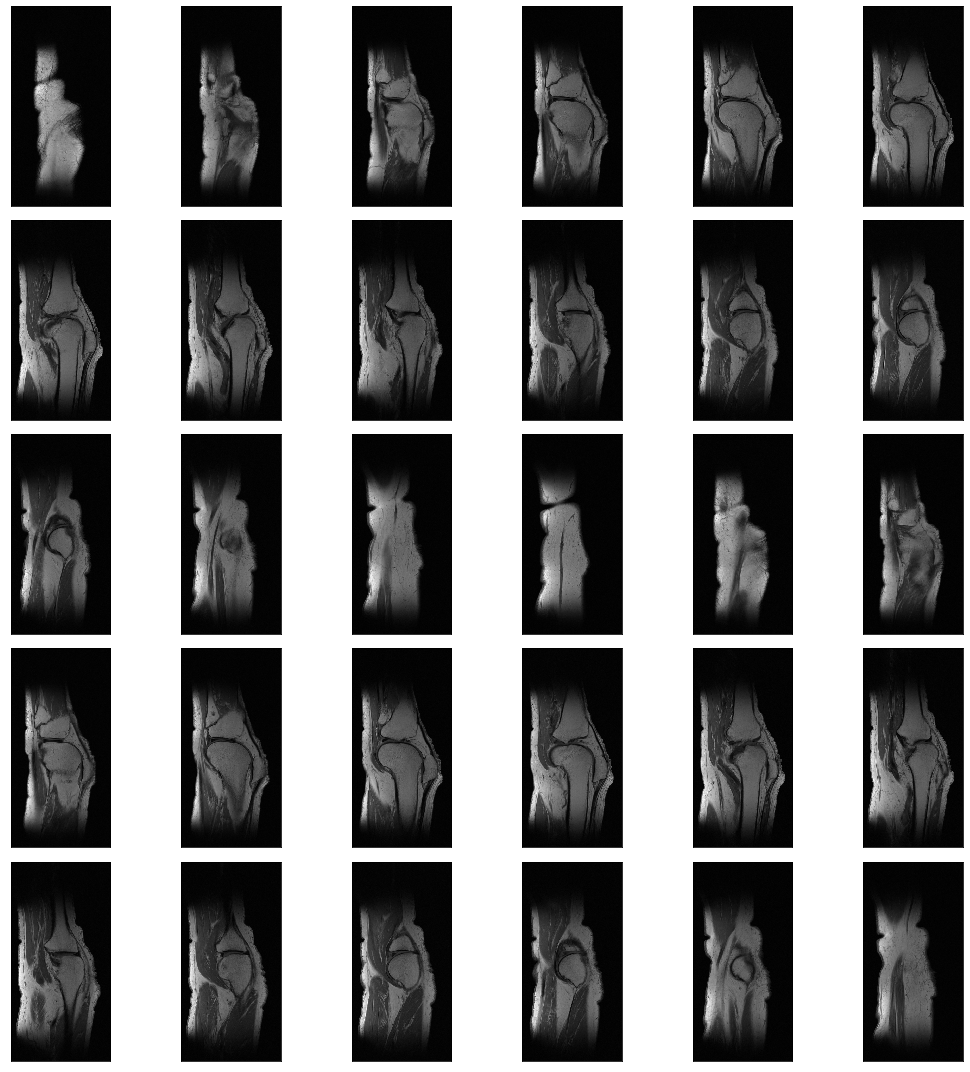

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.imshow(img[i,...], cmap='gray')
    plt.xticks([]);  plt.yticks([])
plt.tight_layout()
plt.show()

In [17]:
uuid

'413469fd-9354-400c-88e3-b29e7c711a05'